# Figure Generation for Manuscript

## Overview
This notebook outlines the generation of **Supplementary Figures S2 and S5** for the manuscript. Detailed steps, including data processing, visualization parameters, and export settings, are included to ensure reproducibility.

---

## **Supplementary Figure S2: Full Yeast PPI Network Analysis**
### Description
Supplementary Figure S2 presents RISK analysis of the **full yeast protein–protein interaction (PPI) network**, retaining all connected nodes to ensure completeness. This analysis provides a direct comparison of **RISK and SAFE** on the **largest fully connected PPI graph**, reinforcing that the original filtering for proteins with **≥6 interactions** was primarily for visualization clarity.

### Generation Steps
1. Load the **full yeast PPI network**, ensuring all connected components are retained.
2. Apply **RISK** to generate functional clusters with **GO BP annotations**.
3. Perform a **comparative analysis** of clustering outputs between RISK and SAFE.
4. Compute **overrepresentation metrics** to evaluate functional coherence in detected clusters.
5. Visualize the network with **functionally enriched biological processes**.
6. Export the figure in high-resolution formats (**SVG, PNG**) for publication.

---

## **Supplementary Figure S5: Comparative Analysis of the Yeast PPI Network Using RISK and SAFE**
### Description
Supplementary Figure S5 provides a comparative analysis of **RISK and SAFE** applied to the **largest connected subgraph** of the **yeast PPI network** from **Michaelis et al. (2023)** (**3,839 nodes and 30,955 edges**).

- **(A)** Visualization of the **largest connected subgraph** of the yeast PPI network.
- **(B)** RISK identified **65 Gene Ontology Biological Process (GO BP) clusters** using the **Louvain algorithm**.
- **(C)** SAFE identified **36 GO BP clusters** using the **shortest-path algorithm**.
- **(D)** Quantitative comparison of clustering metrics. RISK exhibited **significantly higher compactness (P < 0.001)** and **separation (P < 0.01)**, producing more cohesive, well-defined clusters. **Statistical comparisons were performed using the Mann-Whitney U test**.

### Generation Steps
1. Load the **full yeast PPI network** and extract the **largest connected subgraph**.
2. Apply **RISK** to generate **65 clusters** using **Louvain clustering**.
3. Apply **SAFE** to generate **36 clusters** using **shortest-path clustering**.
4. Compare clustering metrics (**compactness, separation**) using statistical tests.
5. Export high-resolution figure panels for manuscript submission.

---

## Workflow
- **Input Data**: Full yeast PPI network, RISK and SAFE clustering outputs.
- **Tools Used**: Python, RISK, Cytoscape, NetworkX, Matplotlib/Seaborn.
- **Output**: High-resolution figures for **Supplementary Figures S2 and S5**.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import risk

In [2]:
# Check the version of the RISK package to ensure it's installed correctly

risk.__version__

'0.0.11'

In [3]:
# Load RISK object and initialize

from risk import RISK

risk = RISK(verbose=True)

In [4]:
# Load the network from a Cytoscape file for RISK analysis

network = risk.load_cytoscape_network(
    filepath="./data/cytoscape/michaelis_2023_full.cys",
    source_label="source",
    target_label="target",
    view_name="",
    compute_sphere=True,
    surface_depth=0.1,
    min_edges_per_node=0,
)

# Load GO Biological Process (BP) annotations from a JSON file and associate them with the existing network
annotations = risk.load_json_annotation(
    network=network,
    filepath="./data/json/annotations/go_biological_process.json",
    min_nodes_per_term=1,
)

---------------
Loading network
---------------
Filetype: Cytoscape
Filepath: ./data/cytoscape/michaelis_2023_full.cys
Minimum edges per node: 0
Projection: Sphere
Surface depth: 0.1
Initial node count: 3839
Final node count: 3839
Initial edge count: 30955
Final edge count: 30955
-------------------
Loading annotations
-------------------
Filetype: JSON
Filepath: ./data/json/annotations/go_biological_process.json
Minimum number of nodes per annotation term: 1
Number of input annotation terms: 2214
Number of remaining annotation terms: 2154


In [5]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods = risk.load_neighborhoods_by_permutation(
    network=network,
    annotations=annotations,
    distance_metric="louvain",
    louvain_resolution=10.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.275,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=6,
)

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 6
Null distribution: 'network'
Distance metric: 'louvain (resolution=10.0)'
Edge length threshold: 0.275
Random seed: 887


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.26it/s]


In [6]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotations=annotations,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.05,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.125,
    linkage_criterion="distance",
    linkage_method="single",
    linkage_metric="dice",
    linkage_threshold="0.126",
    min_cluster_size=4,
    max_cluster_size=1_000,
)

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.05
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.125
-----------------------
Finding top annotations
-----------------------
Min cluster size: 4
Max cluster size: 1000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating optimal linkage method and metric: 100%|███████████████████████████████████| 1/1 [00:04<00:00]


Linkage criterion: 'distance'
Linkage method: 'single'
Linkage metric: 'dice'
Linkage threshold: 0.126


In [ ]:
# Set random seed for reproducibility
random_seed = 801

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.03,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=225,
        nonsignificant_size=12.5,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.04,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot KDE-based contours around network nodes
plotter.plot_contours(
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color=plotter.get_annotated_contour_colors(
        cmap="gist_rainbow",
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.1,
    offset=0.12,
    font="Lato",
    fontcase={"title": "lower"},
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=28,
    min_label_lines=2,
    max_label_lines=4,
    min_chars_per_line=3,
    max_chars_per_line=12,
    words_to_omit=[
        "process",
        "cvt",
        "compound",
        "one-carbon",
        "response",
        "poly",
        "transduction",
        "generate",
        "involved",
        "cell",
        "between",
        "global",
        "biosynthetic",
        "positive",
        "negative",
        "protein",
        "complex",
        "changes",
        "cis",
        "ii",
    ],
    overlay_ids=False,
    ids_to_keep=[
        4,
        7,
        10,
        17,
        21,
        26,
        30,
        32,
        33,
        34,
        35,
        46,
        48,
        54,
        55,
        63,
        65,
        68,
        76,
        83,
        84,
        86,
        87,
        89,
        93,
        95,
        96,
        97,
    ],
    ids_to_labels=None,
)

# Save fig in publication folder
# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/publication/supp_fig_2.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()

---------------
Loading plotter
---------------


## Supplementary Figure S5.A

Empty full yeast protein interactome network

---------------
Loading plotter
---------------


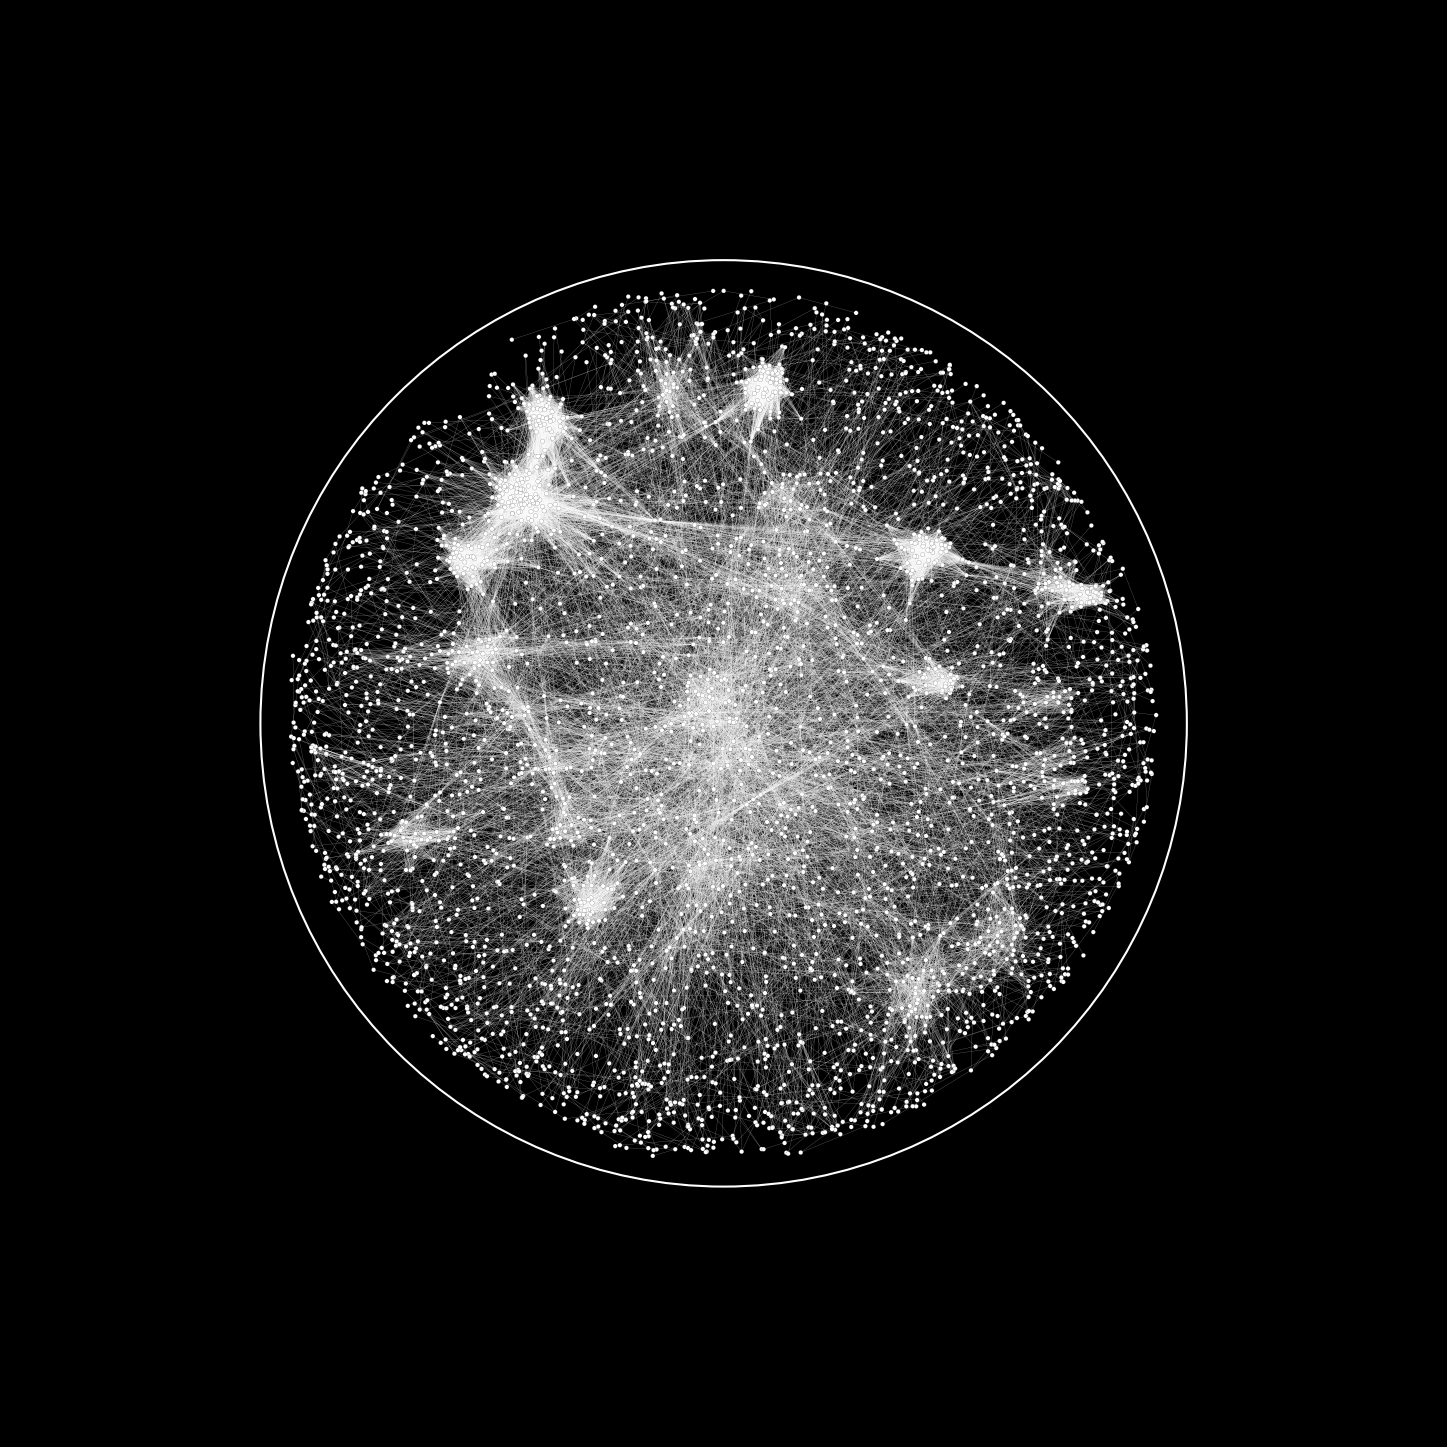

In [9]:
# Set random seed for reproducibility
random_seed = 801

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=10,
        nonsignificant_size=10,
    ),
    node_shape="o",
    node_edgewidth=0.1,
    edge_width=0.1,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/publication/supp_fig_5a.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()

## Supplementary Figure S5.B

RISK analysis of the full yeast interactome network

---------------
Loading plotter
---------------


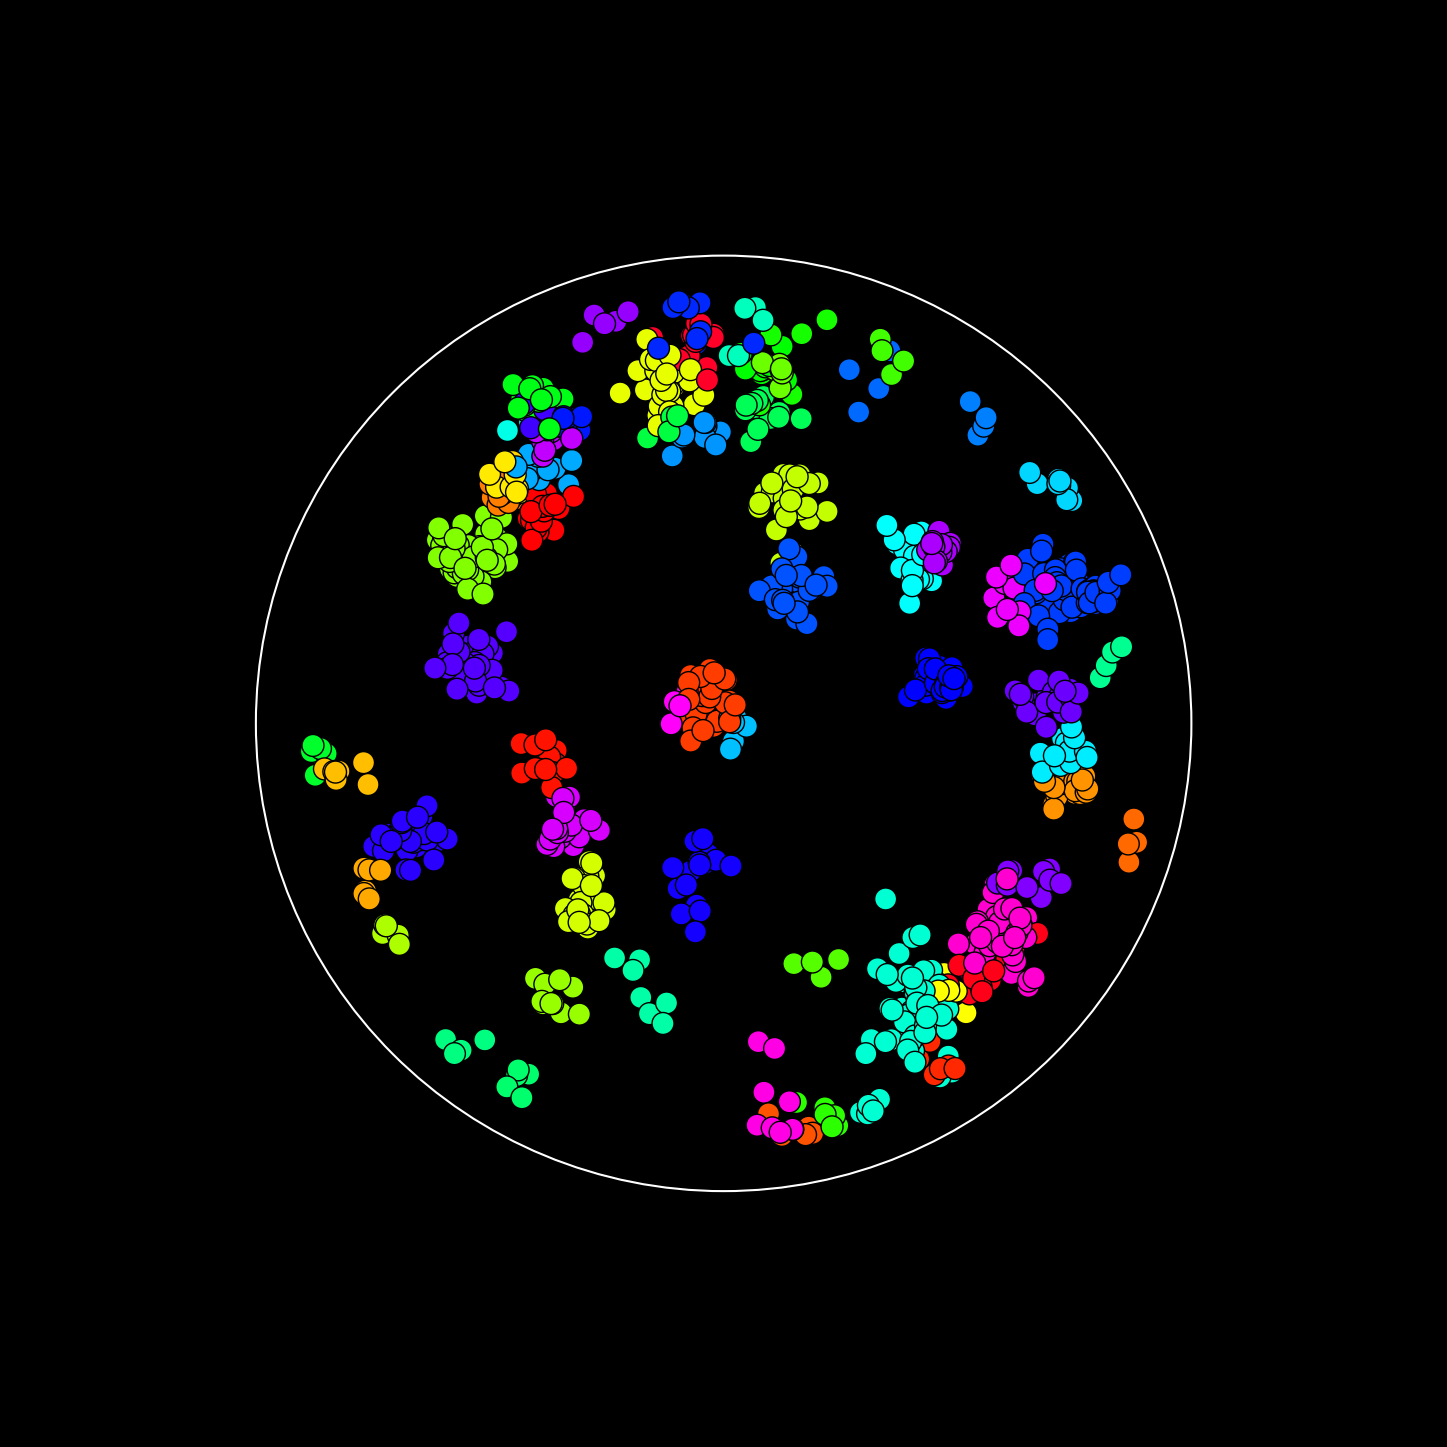

In [10]:
# Set random seed for reproducibility
random_seed = 801

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.03,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=250,
        nonsignificant_size=0,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.0,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/publication/supp_fig_5b.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()

## Supplementary Figure S5.D (Figure S5.C in a separate notebook using SAFE)

RISK vs SAFE analysis of the full yeast interactome network (bar plot)

In [11]:
import matplotlib.pyplot as plt

# Set the background to black for all plots
plt.rcParams["figure.facecolor"] = "black"  # Set the figure background color
plt.rcParams["axes.facecolor"] = "black"  # Set the axes background color
plt.rcParams["savefig.facecolor"] = "black"  # Set the background for saved figures
plt.rcParams["axes.edgecolor"] = "white"  # Optional: Make the axis edge white for visibility
plt.rcParams["axes.labelcolor"] = "white"  # Optional: Make axis labels white
plt.rcParams["xtick.color"] = "white"  # Optional: Make x-ticks white
plt.rcParams["ytick.color"] = "white"  # Optional: Make y-ticks white
plt.rcParams["text.color"] = "white"  # Optional: Set text color to white

In [12]:
import json


def read_json_from_file(filename):
    with open(filename, "r") as file:
        return json.load(file)


def write_json_to_file(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

In [13]:
# Define base network to use as a reference for distance-related analyses

base_network = graph.network.copy()

In [14]:
# Get RISK domain to ids

risk_domain_to_ids_map = graph.domain_id_to_node_ids_map
risk_domain_to_labels_map = graph.domain_id_to_node_labels_map
print(f"Number of domains in RISK: {len(risk_domain_to_ids_map)}")

Number of domains in RISK: 65


In [15]:
# Get SAFE domain to ids

# Read the JSON file and load it into a Python dictionary - 2024-11-05 is a sufficient
with open(
    "../safe_network/data/json/domains/20250130_safe_domains_michaelis_2023_full.json", "r"
) as json_file:
    safe_domain_to_labels_map = {int(k): v for k, v in json.load(json_file).items()}
    # Remove 0 domain - it's garbage collection
    safe_domain_to_labels_map.pop(0)
    safe_domain_to_ids_map = {
        k: [graph.node_label_to_node_id_map[v_] for v_ in v]
        for k, v in safe_domain_to_labels_map.items()
    }

print(f"Number of domains in SAFE: {len(safe_domain_to_ids_map)}")

Number of domains in SAFE: 36


In [16]:
from itertools import combinations
import numpy as np
from sklearn.metrics import silhouette_score


def calculate_network_diameter(network, exact=False):
    """Calculate the network diameter (maximum Euclidean distance) efficiently."""
    positions = np.array([[node_data["x"], node_data["y"]] for node_data in network.nodes.values()])

    if not exact:
        # Approximation using bounding box
        min_x, max_x = positions[:, 0].min(), positions[:, 0].max()
        min_y, max_y = positions[:, 1].min(), positions[:, 1].max()

        # Compute distances between extreme points of the bounding box
        extreme_points = [[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]]
        max_distance = max(
            np.linalg.norm(np.array(p1) - np.array(p2))
            for p1, p2 in combinations(extreme_points, 2)
        )
    else:
        # Exact calculation for all pairs (O(n^2))
        max_distance = max(
            np.linalg.norm(positions[i] - positions[j])
            for i, j in combinations(range(len(positions)), 2)
        )

    return max_distance


def calculate_clustering_metrics(network, domain_to_ids_map, network_diameter=None):
    compactness_scores = {}
    separation_scores = {}

    # Initialize lists for silhouette score calculation
    X = []  # List of node positions
    labels = []  # Corresponding list of cluster labels for each node

    # Compute network diameter if not provided
    if network_diameter is None:
        network_diameter = calculate_network_diameter(network, exact=False)

    # Ensure we don't divide by zero
    if network_diameter == 0:
        network_diameter = 1.0

    # Calculate compactness and separation
    centroids = {}
    for domain, node_ids in domain_to_ids_map.items():
        positions = np.array(
            [[network.nodes[node_id]["x"], network.nodes[node_id]["y"]] for node_id in node_ids]
        )

        # Compactness: Average pairwise distance within each cluster (normalized)
        if len(positions) > 1:
            pairwise_distances = [
                np.linalg.norm(positions[i] - positions[j])
                for i, j in combinations(range(len(positions)), 2)
            ]
            compactness_scores[domain] = np.mean(pairwise_distances) / network_diameter
        else:
            compactness_scores[domain] = 0  # Single-node clusters have 0 compactness by definition

        # Compute centroid for separation calculation
        centroids[domain] = np.mean(positions, axis=0)

        # Collect positions and labels for silhouette score calculation
        for pos in positions:
            X.append(pos)
            labels.append(domain)

    # Convert X and labels to NumPy arrays for consistency
    X = np.array(X)
    labels = np.array(labels)

    # Calculate separation: Minimum distance to other cluster centroids (normalized)
    for domain, centroid in centroids.items():
        other_centroids = [centroids[other] for other in centroids if other != domain]
        if other_centroids:
            min_separation = min(
                np.linalg.norm(centroid - other_centroid) for other_centroid in other_centroids
            )
            separation_scores[domain] = min_separation / network_diameter
        else:
            separation_scores[domain] = 0  # Only one cluster case

    # Calculate overall silhouette score
    overall_silhouette_score = silhouette_score(X, labels)

    # Return metrics
    return {
        "compactness": compactness_scores,
        "separation": separation_scores,
        "silhouette_score": overall_silhouette_score,
    }

In [17]:
# SAFE
# Precompute network diameter

safe_network_diameter = calculate_network_diameter(base_network, exact=False)
# Calculate clustering metrics
safe_metrics = calculate_clustering_metrics(
    base_network, safe_domain_to_ids_map, network_diameter=safe_network_diameter
)

# print("Compactness per cluster:", safe_metrics['compactness'])
# print("Separation per cluster:", safe_metrics['separation'])
print("Overall Silhouette Score:", safe_metrics["silhouette_score"])

Overall Silhouette Score: 0.3176120548886251


In [18]:
# RISK
# Precompute network diameter

risk_network_diameter = calculate_network_diameter(base_network, exact=False)
# Calculate clustering metrics
risk_metrics = calculate_clustering_metrics(
    base_network, risk_domain_to_ids_map, network_diameter=risk_network_diameter
)

# print("Compactness per cluster:", risk_metrics['compactness'])
# print("Separation per cluster:", risk_metrics['separation'])
print("Overall Silhouette Score:", risk_metrics["silhouette_score"])

Overall Silhouette Score: 0.35296430537697254


In [19]:
# This script compares clustering metrics (compactness and separation) between RISK and SAFE.
# It selects the top N clusters based on compactness for each tool, where N is the maximum common cluster count.
# Metrics are then recalculated and summarized as means and standard deviations for compactness and separation.
# Assumes `safe_metrics` and `risk_metrics` are precomputed dictionaries with 'compactness', 'separation',
# and 'silhouette_score' as keys and domain-specific metrics as values.

import numpy as np


# Assume safe_metrics and risk_metrics have already been calculated
safe_compactness = safe_metrics["compactness"]
risk_compactness = risk_metrics["compactness"]
safe_separation = safe_metrics["separation"]
risk_separation = risk_metrics["separation"]
safe_silhouette = safe_metrics["silhouette_score"]
risk_silhouette = risk_metrics["silhouette_score"]

# Determine the max count of clusters between SAFE and RISK
max_cluster_count = min(len(safe_compactness), len(risk_compactness))

# Sort and select top N clusters based on compactness
top_safe_compactness = dict(
    sorted(safe_compactness.items(), key=lambda item: item[1])[:max_cluster_count]
)
top_risk_compactness = dict(
    sorted(risk_compactness.items(), key=lambda item: item[1])[:max_cluster_count]
)

top_safe_separation = {domain: safe_separation[domain] for domain in top_safe_compactness}
top_risk_separation = {domain: risk_separation[domain] for domain in top_risk_compactness}

# Re-calculate the means of the selected top clusters
safe_compactness_mean = np.mean(list(top_safe_compactness.values()))
safe_compactness_std = np.std(list(top_safe_compactness.values()))
risk_compactness_mean = np.mean(list(top_risk_compactness.values()))
risk_compactness_std = np.std(list(top_risk_compactness.values()))

safe_separation_mean = np.mean(list(top_safe_separation.values()))
safe_separation_std = np.std(list(top_safe_separation.values()))
risk_separation_mean = np.mean(list(top_risk_separation.values()))
risk_separation_std = np.std(list(top_risk_separation.values()))

# Print results
print("Top N SAFE Compactness (mean, std):", safe_compactness_mean, safe_compactness_std)
print("Top N RISK Compactness (mean, std):", risk_compactness_mean, risk_compactness_std)
print("Top N SAFE Separation (mean, std):", safe_separation_mean, safe_separation_std)
print("Top N RISK Separation (mean, std):", risk_separation_mean, risk_separation_std)

Top N SAFE Compactness (mean, std): 0.04615026486384822 0.03658315703859629
Top N RISK Compactness (mean, std): 0.016229749456744876 0.0028916870153680176
Top N SAFE Separation (mean, std): 0.04191127764381694 0.023178272557083563
Top N RISK Separation (mean, std): 0.034255523749537616 0.022363244652590607


# SAFE Groups: 36 : # RISK Groups: 65
Compactness Mann-Whitney U: U=1931.5, p-value=3.407951768154439e-08
Separation Mann-Whitney U: U=1205.0, p-value=0.5993790873893904
Silhouette Score Mann-Whitney U: U=0.0, p-value=1.0


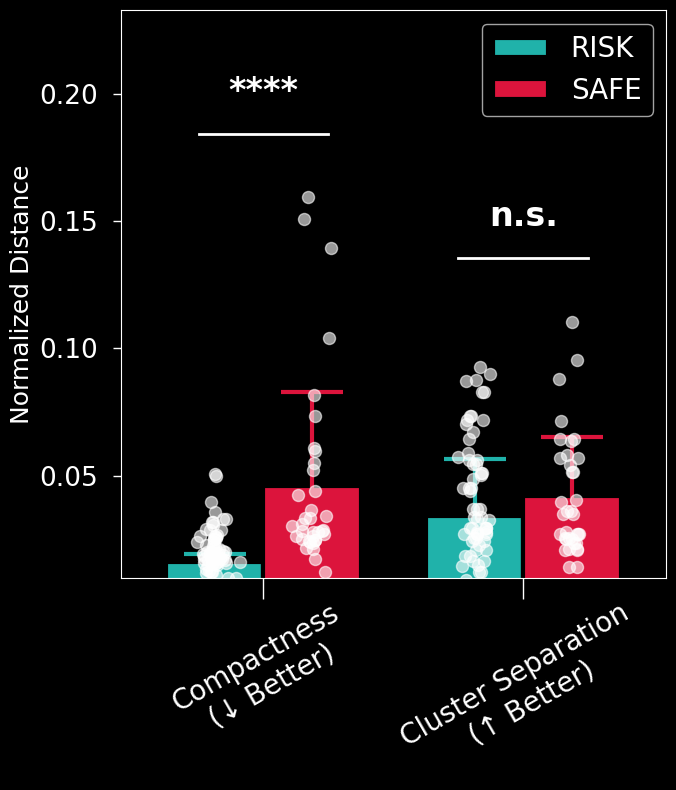

In [20]:
"""
This script generates a comparative bar chart and scatter plot to visualize clustering metrics 
(compactness, separation, silhouette score) for SAFE and RISK. It includes statistical significance 
testing using the Mann-Whitney U test to assess differences between the tools. Annotations highlight 
significant results directly on the plot. This visualization is tailored for publication-quality 
figures and supports a critical evaluation of clustering performance across metrics.

Key Features:
1. Bar chart with error bars for compactness and separation.
2. Scatter points for silhouette scores.
3. Jittered scatter points overlaid on bars to represent individual cluster metrics.
4. Mann-Whitney U test results annotated for significance.
5. Flexible y-axis range adjustment and aesthetic customization for publication readiness.

Inputs:
- Precomputed SAFE and RISK metrics (compactness, separation, silhouette scores).
- Statistical significance thresholds for Mann-Whitney U test annotations.

Outputs:
- Comparative bar chart with significance annotations.
- Printout of Mann-Whitney U test results for compactness, separation, and silhouette score.
"""

from matplotlib.ticker import MultipleLocator
from scipy.stats import mannwhitneyu


np.random.seed(888)

# Example data (replace with actual values)
metrics = [
    "Compactness\n(↓ Better)",
    "Cluster Separation\n(↑ Better)",
    "Silhouette Score\n(↑ Better)",
]
safe_means = [safe_compactness_mean, safe_separation_mean, safe_silhouette]
safe_stds = [safe_compactness_std, safe_separation_std, 0]  # No std deviation for silhouette
risk_means = [risk_compactness_mean, risk_separation_mean, risk_silhouette]
risk_stds = [risk_compactness_std, risk_separation_std, 0]  # No std deviation for silhouette

print(f"# SAFE Groups: {len(safe_compactness)} : # RISK Groups: {len(risk_compactness)}")
safe_data = [list(safe_compactness.values()), list(safe_separation.values()), [safe_silhouette]]
risk_data = [list(risk_compactness.values()), list(risk_separation.values()), [risk_silhouette]]

# Bar chart settings
fig, ax = plt.subplots(figsize=(8, 8))
bar_width = 0.375
x = np.arange(len(metrics) - 1)

safe_color = "#DC143C"  # Crimson for SAFE
risk_color = "#20B2AA"  # Light Sea Green for RISK

# Plot RISK bars first (swap positions with SAFE)
ax.bar(
    x - bar_width / 2,
    risk_means[:2],
    bar_width,
    yerr=risk_stds[:2],
    color=risk_color,
    edgecolor="black",
    linewidth=3,
    capsize=22,
    label="RISK",
    error_kw=dict(ecolor=risk_color, lw=3, capthick=3),
)
ax.bar(
    x + bar_width / 2,
    safe_means[:2],
    bar_width,
    yerr=safe_stds[:2],
    color=safe_color,
    edgecolor="black",
    linewidth=3,
    capsize=22,
    label="SAFE",
    error_kw=dict(ecolor=safe_color, lw=3, capthick=3),
)

# Overlay white jittered scatter points with transparency for RISK
for i, data in enumerate(risk_data[:2]):
    jitter = np.random.normal(0, 0.03, len(data))  # Small jitter
    ax.scatter(
        np.full(len(data), x[i] - bar_width / 2) + jitter,
        data,
        color="white",
        s=75,
        alpha=0.6,
        zorder=3,
    )

# Overlay white jittered scatter points with transparency for SAFE
for i, data in enumerate(safe_data[:2]):
    jitter = np.random.normal(0, 0.03, len(data))  # Small jitter
    ax.scatter(
        np.full(len(data), x[i] + bar_width / 2) + jitter,
        data,
        color="white",
        s=75,
        alpha=0.6,
        zorder=3,
    )

# Customizations
ax.axhline(
    0, color="white", linewidth=1.5, linestyle="--"
)  # Solid white line at y=0 as reference point
ax.set_xticks(
    np.append(x, x[-1] + 1)
)  # Adjust x-axis ticks to include the silhouette score position
ax.set_xticklabels(metrics, fontsize=20)  # Set x-axis label font size

# Extend x and y tick marks
ax.tick_params(axis="x", pad=0, length=15, width=1)  # Extend x-axis tick marks towards labels
ax.tick_params(axis="y", pad=10, length=6, width=1)  # Extend y-axis tick marks towards labels

# CHANGE HERE FOR YLIM
correction = (max(safe_data[0]) - min(safe_data[0])) * 0.5
ax.set_ylim(0.01, max(safe_data[0]) + correction)  # Adjust the y-axis range as needed
ax.legend(loc="upper right", fontsize=20)  # Increase legend font size
# Set the y-axis tick interval
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_ylabel("Normalized Distance", fontsize=18)
ax.tick_params(axis="y", labelsize=19)  # Customize y-tick font size

plt.xticks(rotation=30)  # Rotate x-tick labels
plt.tight_layout()
# Create a 5% (0.05) and 10% (0.1) padding in the
# x and y directions respectively.
plt.margins(0.1, 0)

# Convert compactness and separation to lists of numeric values
safe_compactness_values = list(safe_compactness.values())
risk_compactness_values = list(risk_compactness.values())
safe_separation_values = list(safe_separation.values())
risk_separation_values = list(risk_separation.values())

# Perform Mann-Whitney U test for each metric
compactness_stat, compactness_p = mannwhitneyu(
    safe_compactness_values, risk_compactness_values, alternative="greater"
)
separation_stat, separation_p = mannwhitneyu(
    safe_separation_values, risk_separation_values, alternative="less"
)
silhouette_stat, silhouette_p = mannwhitneyu(
    [safe_metrics["silhouette_score"]], [risk_metrics["silhouette_score"]], alternative="two-sided"
)

# Print results
print(f"Compactness Mann-Whitney U: U={compactness_stat}, p-value={compactness_p}")
print(f"Separation Mann-Whitney U: U={separation_stat}, p-value={separation_p}")
print(f"Silhouette Score Mann-Whitney U: U={silhouette_stat}, p-value={silhouette_p}")

# Define significance thresholds
significance_annotations = {
    "****": 0.0001,
    "***": 0.001,
    "**": 0.01,
    "*": 0.05,
}


def get_significance_text(p_value):
    for text, threshold in significance_annotations.items():
        if p_value <= threshold:
            return text
    return "n.s."  # Not significant


# Get significance text for each metric
compactness_text = get_significance_text(compactness_p)
separation_text = get_significance_text(separation_p)

# Annotate significance on the plot
safe_compactness_height = max(safe_compactness_values) + 0.025
ax.text(
    0,
    safe_compactness_height + 0.01,
    compactness_text,
    ha="center",
    va="bottom",
    color="white",
    weight="bold",
    fontsize=24,
)
ax.plot(
    [-0.25, 0.25], [safe_compactness_height, safe_compactness_height], color="white", linewidth=2
)

risk_separation_height = max(safe_separation_values) + 0.025
ax.text(
    1,
    risk_separation_height + 0.01,
    separation_text,
    ha="center",
    va="bottom",
    color="white",
    weight="bold",
    fontsize=24,
)
ax.plot([0.75, 1.25], [risk_separation_height, risk_separation_height], color="white", linewidth=2)

# 1,200 DPI required for line art in journal Bioinformatics
# plt.savefig("./png/publication/supp_fig_5d.png", bbox_inches="tight", dpi=1200)

plt.show()

## Additional analysis

This section is to back a claim made about the trimmed yeast PPI network in section 3.1 of the manuscript:

"RISK identified compact, functionally enriched clusters that reveal modular biological organization, such as pyrimidine metabolism, mitochondrial organization, and RNA polymerase activity (P < 0.0001)."

In [21]:
# Perform separate statistical test to achieve higher P-value resolution per annotation term

# Use chi-squared test for speed
neighborhoods_chi2 = risk.load_neighborhoods_by_chi2(
    network=network,
    annotations=annotations,
    distance_metric="louvain",
    louvain_resolution=10.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.275,
    null_distribution="network",
    random_seed=887,
)
graph_chi2 = risk.load_graph(
    network=network,
    annotations=annotations,
    neighborhoods=neighborhoods_chi2,
    tail="right",
    pval_cutoff=0.05,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.125,
    linkage_criterion="distance",
    linkage_method="single",
    linkage_metric="dice",
    min_cluster_size=4,
    max_cluster_size=1_000,
)

------------------------
Running chi-squared test
------------------------
Null distribution: 'network'
Distance metric: 'louvain (resolution=10.0)'
Edge length threshold: 0.275
Random seed: 887
---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.05
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.125
-----------------------
Finding top annotations
-----------------------
Min cluster size: 4
Max cluster size: 1000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating optimal linkage method and metric: 100%|███████████████████████████████████| 1/1 [00:00<00:00]


Linkage criterion: 'distance'
Linkage method: 'single'
Linkage metric: 'dice'
Linkage threshold: 0.2


In [22]:
# Load table mapping significance to annotation terms

graph_chi2_summary = graph_chi2.summary.load()
graph_chi2_summary = graph_chi2_summary.sort_values("Enrichment P-Value")

# Define the keywords to search for in the annotations.
keywords = ["pyrimidine", "mitoch", "RNA polym"]

# Loop over each keyword, filter the DataFrame, and print the top 5 results.
# (We assume that the DataFrame has a column called 'Annotation' that holds the annotation text.)
for keyword in keywords:
    print(f"Results for '{keyword}':")
    # Filter rows where 'Annotation' contains the keyword (case-insensitive)
    matches = graph_chi2_summary[
        graph_chi2_summary["Annotation"].str.contains(keyword, case=False, na=False)
    ]
    # Sort the filtered results by 'Enrichment P-value'
    matches = matches.sort_values("Enrichment P-Value")
    # Get the top 5 results (or fewer if there aren't enough matches)
    top_matches = matches.head(5)

    # Check if there are any matches at all
    if top_matches.empty:
        print("  No matching annotations found.")
    else:
        # Print each matching annotation and its corresponding p-value
        for idx, row in top_matches.iterrows():
            annotation = row["Annotation"]
            p_value = row["Enrichment P-Value"]
            print(f"  {annotation}: {p_value}")

    # Add a blank line between keyword sections for readability
    print()

------------------------
Loading analysis summary
------------------------
Results for 'pyrimidine':
  pyrimidine deoxyribonucleoside triphosphate biosynthetic process: 6.18995636877556e-106
  pyrimidine deoxyribonucleoside triphosphate metabolic process: 4.111686801441657e-71
  pyrimidine deoxyribonucleotide biosynthetic process: 4.111686801441657e-71
  pyrimidine ribonucleoside diphosphate metabolic process: 2.0289273224593132e-45
  pyrimidine nucleoside triphosphate biosynthetic process: 1.754027380864245e-27

Results for 'mitoch':
  mitochondrial ATP synthesis coupled electron transport: 1.2239999757825735e-244
  mitochondrial electron transport, ubiquinol to cytochrome c: 2.9060331590622396e-203
  mitochondrial electron transport, cytochrome c to oxygen: 1.520716821037588e-116
  mitochondrial tRNA thio-modification: 6.18995636877556e-106
  mitochondrial tRNA modification: 6.18995636877556e-106

Results for 'RNA polym':
  tRNA transcription by RNA polymerase III: 0.0
  transcriptio